## Week 4 Assignment
### 对用户进行聚类

In [1]:
import numpy as np
import pandas as pd

from sklearn.cluster import MiniBatchKMeans
from sklearn.model_selection import train_test_split
from sklearn import metrics
import time


import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
dpath = "/Users/Yubo/Desktop/AI/CSDN_AI_Eng/csdn_week4/week4_homework/"
df = pd.read_csv(dpath + "users.csv")
df.head()

,user_id,locale,birthyear,gender,joinedAt,location,timezone
0,3197468391,id_ID,1993,male,2012-10-02T06:40:55.524Z,Medan Indonesia,480.0
1,3537982273,id_ID,1992,male,2012-09-29T18:03:12.111Z,Medan Indonesia,420.0
2,823183725,en_US,1975,male,2012-10-06T03:14:07.149Z,Stratford Ontario,-240.0
3,1872223848,en_US,1991,female,2012-11-04T08:59:43.783Z,Tehran Iran,210.0
4,3429017717,id_ID,1995,female,2012-09-10T16:06:53.132Z,NaN,420.0


In [3]:
n_records = df.shape[0]
n_records

38209

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38209 entries, 0 to 38208
Data columns (total 7 columns):
user_id      38209 non-null int64
locale       38209 non-null object
birthyear    38209 non-null object
gender       38100 non-null object
joinedAt     38152 non-null object
location     32745 non-null object
timezone     37773 non-null float64
dtypes: float64(1), int64(1), object(5)
memory usage: 2.0+ MB


In [5]:
def get_uniqueUsers():
    uniqueUsers = set()
    
    for i in range(n_records):
        uniqueUsers.add(df.loc[i,'user_id'])
    
    n_events = len(uniqueUsers)
    return n_events

n_users = get_uniqueUsers()

In [6]:
n_users

38209

In [7]:
#user_id不作为聚类属性
df = df.drop(["user_id"], axis=1)
        
#location有缺失值，粗暴抛弃
#也可以将缺失值作为另外一类：others
df = df.drop(["location"], axis=1)
df.head()

,locale,birthyear,gender,joinedAt,timezone
0,id_ID,1993,male,2012-10-02T06:40:55.524Z,480.0
1,id_ID,1992,male,2012-09-29T18:03:12.111Z,420.0
2,en_US,1975,male,2012-10-06T03:14:07.149Z,-240.0
3,en_US,1991,female,2012-11-04T08:59:43.783Z,210.0
4,id_ID,1995,female,2012-09-10T16:06:53.132Z,420.0


In [8]:
#特征编码
import datetime
import hashlib
import locale

from collections import defaultdict
from sklearn.preprocessing import normalize

class FeatureEng:
    def __init__(self):
         # 载入 locales
        self.localeIdMap = defaultdict(int)
        for i, l in enumerate(locale.locale_alias.keys()):
          self.localeIdMap[l] = i + 1
        
        # 载入 gender id 字典
        ##缺失补0
        self.genderIdMap = defaultdict(int, {'NaN': 0, "male":1, "female":2})

  
    def getLocaleId(self, locstr):
        return self.localeIdMap[locstr.lower()]

    def getGenderId(self, genderStr):
        return self.genderIdMap[genderStr]

    def getJoinedYearMonth(self, dateString):
        try:
            dttm = datetime.datetime.strptime(dateString, "%Y-%m-%dT%H:%M:%S.%fZ")
            #return "".join([str(dttm.year), str(dttm.month)])
            return (dttm.year-2010)*12 + dttm.month
        except:  #缺失补0
          return 0

    def getBirthYearInt(self, birthYear):
        #缺失补0
        try:
          return 0 if birthYear == "None" else int(birthYear)
        except:
          return 0

    def getTimezoneInt(self, timezone):
        try:
          return int(timezone)
        except:  #缺失值处理
          return 0

In [9]:
FE = FeatureEng()

cols = ['LocaleId', 'BirthYearInt', 'GenderId', 'JoinedYearMonth', 'TimezoneInt']
n_cols = len(cols)
userMatrix = np.zeros((df.shape[0],n_cols), dtype=np.int)

for i in range(df.shape[0]): 
    userMatrix[i, 0] = FE.getLocaleId(df.loc[i,'locale'])
    userMatrix[i, 1] = FE.getBirthYearInt(df.loc[i,'birthyear'])
    userMatrix[i, 2] = FE.getGenderId(df.loc[i,'gender'])
    userMatrix[i, 3] = FE.getJoinedYearMonth(df.loc[i,'joinedAt'])
    #userMatrix[i, 4] = FE.getCountryId(df[''])
    userMatrix[i, 4] = FE.getTimezoneInt(df.loc[i,'timezone'])

# 归一化用户矩阵
userMatrix = normalize(userMatrix, norm="l1", axis=0, copy=False)

df_FE = pd.DataFrame(data=userMatrix, columns=cols)  
#mmwrite("US_userMatrix", userMatrix)

/Users/Yubo/anaconda3/envs/py27/lib/python2.7/site-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype int64 was converted to float64 by the normalize function.
  warnings.warn(msg, _DataConversionWarning)


In [10]:
df_FE.head()

,LocaleId,BirthYearInt,GenderId,JoinedYearMonth,TimezoneInt
0,0.000020,0.000027,0.000019,0.000026,0.000036
1,0.000020,0.000027,0.000019,0.000026,0.000031
2,0.000028,0.000027,0.000019,0.000026,-0.000018
3,0.000028,0.000027,0.000038,0.000027,0.000016
4,0.000020,0.000027,0.000038,0.000026,0.000031


In [13]:
# 一个参数点（聚类数据为K）的模型，在校验集上评价聚类算法性能
def K_cluster_analysis(K, X_train):
    start = time.time()
    
    print("K-means begin with clusters: {}".format(K));
    
    #K-means,在训练集上训练
    mb_kmeans = MiniBatchKMeans(n_clusters = K)
    mb_kmeans.fit(X_train)
    
    # 在训练集和测试集上测试
    #y_train_pred = mb_kmeans.fit_predict(X_train)
    y_val_pred = mb_kmeans.predict(X_train)
    
    #以前两维特征打印训练数据的分类结果
    #plt.scatter(X_train[:, 0], X_train[:, 1], c=y_pred)
    #plt.show()

    # K值的评估标准
    #常见的方法有轮廓系数Silhouette Coefficient和Calinski-Harabasz Index
    #这两个分数值越大则聚类效果越好
    #CH_score = metrics.calinski_harabaz_score(X_train,mb_kmeans.predict(X_train))
    CH_score = metrics.silhouette_score(X_train,mb_kmeans.predict(X_train))
    
    #也可以在校验集上评估K
    #v_score = metrics.v_measure_score(y_val, y_val_pred)
    
    end = time.time()
    print("CH_score: {}, time elaps:{}".format(CH_score, int(end-start)))
    #print("v_score: {}".format(v_score))
    
    return CH_score

In [14]:
# 设置超参数（聚类数目K）搜索范围
Ks = [20,40,80]
CH_scores = []

for K in Ks:
    ch = K_cluster_analysis(K, df_FE)
    CH_scores.append(ch)
    #v_scores.append(v)

K-means begin with clusters: 20
CH_score: 0.629285158451, time elaps:1711
K-means begin with clusters: 40
CH_score: 0.629798900885, time elaps:4769
K-means begin with clusters: 80
CH_score: 0.613135921864, time elaps:1143


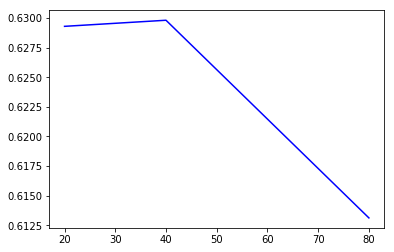

In [15]:
plt.plot(Ks, np.array(CH_scores), 'b-')

40比较好